In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from functools import reduce
import calendar
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.ticker as mtick
import statsmodels.api as sm
import warnings
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go

In [3]:
df = pd.read_csv('hotel_bookings_clean.csv', parse_dates=['arrival_date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118087 entries, 0 to 118086
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118087 non-null  object        
 1   is_canceled                     118087 non-null  bool          
 2   lead_time                       118087 non-null  int64         
 3   arrival_date_month              118087 non-null  object        
 4   stays_in_weekend_nights         118087 non-null  int64         
 5   stays_in_week_nights            118087 non-null  int64         
 6   adults                          118087 non-null  int64         
 7   children                        118087 non-null  int64         
 8   babies                          118087 non-null  int64         
 9   meal                            118087 non-null  object        
 10  market_segment                  118087 non-null  object 

In [5]:
print(df['reservation_status'].value_counts())

reservation_status
Check-Out    73973
Canceled     42925
No-Show       1189
Name: count, dtype: int64


In [6]:
cancelations = (df['reservation_status'] == 'Canceled').sum()
print(cancelations)

42925


In [7]:
total_bookings = df.shape[0]
print(total_bookings)

118087


In [8]:
cancelation_rate = cancelations / total_bookings
print(cancelation_rate)

0.36350317985891756


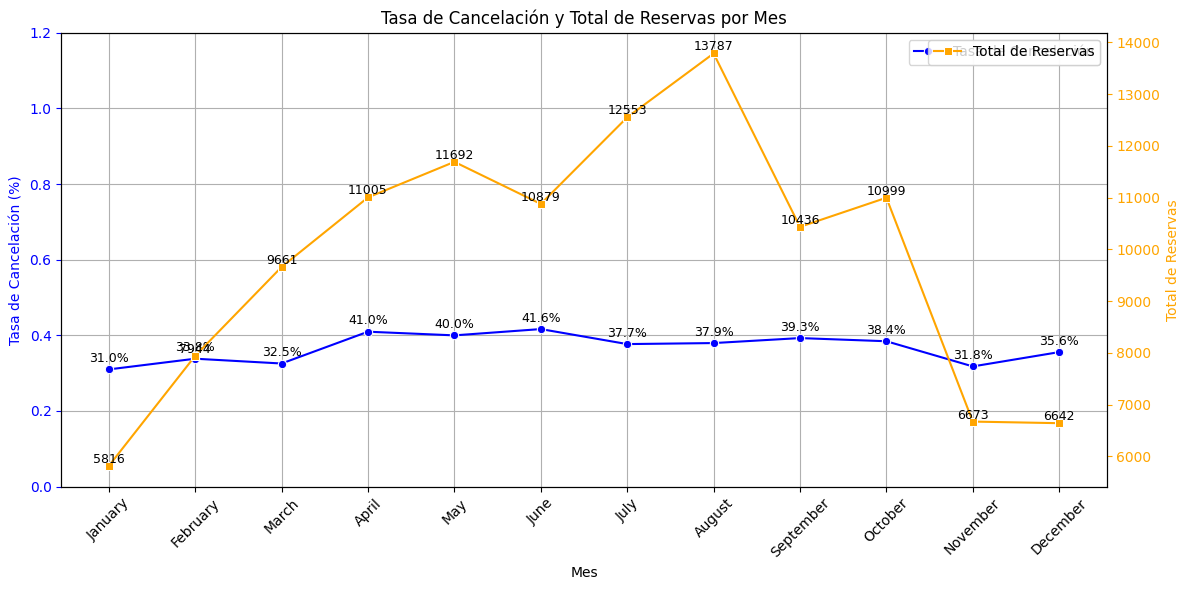

In [9]:
# 2. Asegurar orden correcto de meses y convertir en categoría ordenada
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']
df['arrival_date_month'] = pd.Categorical(
    df['arrival_date_month'],
    categories=month_order,
    ordered=True
)

# 3. Cálculo de tasa de cancelación y total de reservas por mes
monthly = (
    df
    .groupby('arrival_date_month', observed=False)  # evita el FutureWarning
    .agg(
        cancellation_rate=('is_canceled', 'mean'),
        total_reservations=('is_canceled', 'size')
    )
    .reset_index()
)

# 4. Gráfico con doble eje Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# 4a. Tasa de cancelación (eje izquierdo)
sns.lineplot(
    ax=ax1,
    data=monthly,
    x='arrival_date_month',
    y='cancellation_rate',
    marker='o',
    color='blue',
    label='Tasa de Cancelación'
)
# Etiquetas de porcentaje
for idx, row in monthly.iterrows():
    ax1.text(
        idx,
        row.cancellation_rate + 0.02,
        f"{row.cancellation_rate*100:.1f}%",
        ha='center',
        fontsize=9,
        color='black'
    )
ax1.set_ylabel('Tasa de Cancelación (%)', color='blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_ylim(0, 1.2)

# 4b. Total de reservas (eje derecho)
ax2 = ax1.twinx()
sns.lineplot(
    ax=ax2,
    data=monthly,
    x='arrival_date_month',
    y='total_reservations',
    marker='s',
    color='orange',
    label='Total de Reservas'
)
# Etiquetas de total de reservas
for idx, row in monthly.iterrows():
    ax2.text(
        idx,
        row.total_reservations,
        f"{row.total_reservations}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )
ax2.set_ylabel('Total de Reservas', color='orange')
ax2.tick_params(axis='y', colors='orange')

# 5. Personalización común
ax1.set_xlabel('Mes')
plt.title('Tasa de Cancelación y Total de Reservas por Mes')
ax1.set_xticks(range(len(monthly)))
ax1.set_xticklabels(monthly['arrival_date_month'], rotation=45)
ax1.grid(True)

plt.tight_layout()
plt.show()

Coeficiente de correlación (reservas vs tasa de cancelación): 0.574


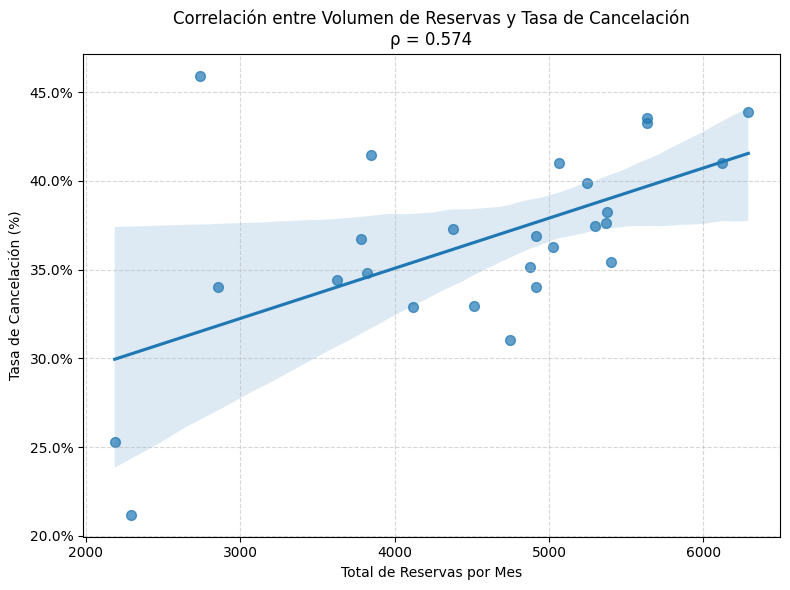

In [85]:
# 1. Carga y asegurarte de que arrival_date esté en datetime
df = pd.read_csv('hotel_bookings_clean.csv')
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# 2. Agrupar por mes (PeriodIndex) y calcular:
#    - total_reservations: cuenta de filas (reservas)
#    - cancellation_rate: media de is_canceled
monthly = (
    df
    .groupby(df['arrival_date'].dt.to_period('M'), observed=False)
    .agg(
        total_reservations=('is_canceled','size'),
        cancellation_rate=('is_canceled','mean')
    )
    .reset_index()
)
# convertir el Period a timestamp para trazar
monthly['month'] = monthly['arrival_date'].dt.to_timestamp()

# 3. Correlación de Pearson
corr_value = monthly['total_reservations'].corr(monthly['cancellation_rate'])
print(f"Coeficiente de correlación (reservas vs tasa de cancelación): {corr_value:.3f}")

# 4. Scatter + línea de regresión
plt.figure(figsize=(8,6))
sns.regplot(
    data=monthly,
    x='total_reservations',
    y='cancellation_rate',
    marker='o',
    scatter_kws={'s':50, 'alpha':0.7}
)
plt.xlabel('Total de Reservas por Mes')
plt.ylabel('Tasa de Cancelación (%)')
plt.title('Correlación entre Volumen de Reservas y Tasa de Cancelación\n'
          f'ρ = {corr_value:.3f}')
# formatear eje Y en %
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


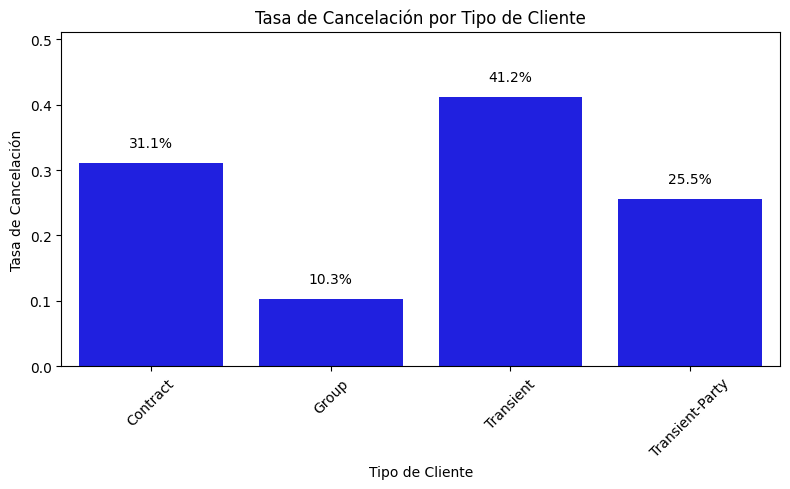

In [11]:
# (Recalcula customer_type_cancellation con observed=False para evitar el FutureWarning:)
customer_type_cancellation = (
    df.groupby('customer_type', observed=False)
      .agg(total_bookings=('is_canceled','count'),
           cancellations=('is_canceled','sum'))
)
customer_type_cancellation['cancellation_rate'] = (
    customer_type_cancellation['cancellations']
    / customer_type_cancellation['total_bookings']
)

fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(
    x=customer_type_cancellation.index,
    y='cancellation_rate',
    data=customer_type_cancellation,
    color='blue',
    ax=ax
)
ax.set_title('Tasa de Cancelación por Tipo de Cliente')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Tasa de Cancelación')
ax.set_ylim(0, customer_type_cancellation['cancellation_rate'].max() + 0.1)
plt.xticks(rotation=45)

# Añadir etiquetas de datos sobre cada barra:
for patch in ax.patches:
    height = patch.get_height()
    x_pos = patch.get_x() + patch.get_width()/2
    ax.text(
        x_pos,
        height + 0.02,
        f"{height*100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()



## Distribucion cancelaciones por tipo de deposito

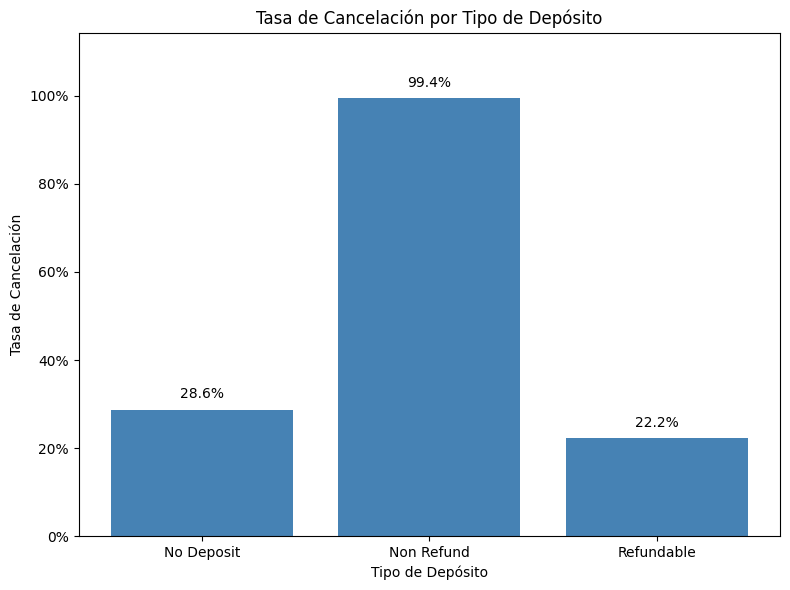

In [13]:
# 2. Agrupar por tipo de depósito y calcular tasa de cancelación
deposit = (
    df
    .groupby('deposit_type', observed=False)
    .agg(
        total=('is_canceled', 'size'),
        canceled=('is_canceled', 'sum')
    )
    .reset_index()
)
deposit['cancel_rate'] = deposit['canceled'] / deposit['total']

# 3. Dibujar el barplot con Matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(
    deposit['deposit_type'],
    deposit['cancel_rate'],
    color='steelblue'
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylim(0, deposit['cancel_rate'].max() * 1.15)

# 5. Anotar porcentajes encima de cada barra
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + 0.02,
        f"{h * 100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# 6. Etiquetas y título
ax.set_xlabel('Tipo de Depósito')
ax.set_ylabel('Tasa de Cancelación')
ax.set_title('Tasa de Cancelación por Tipo de Depósito')

plt.tight_layout()
plt.show()

## Evolucion del adr en funcion del customer_type (de las reservas canceladas)

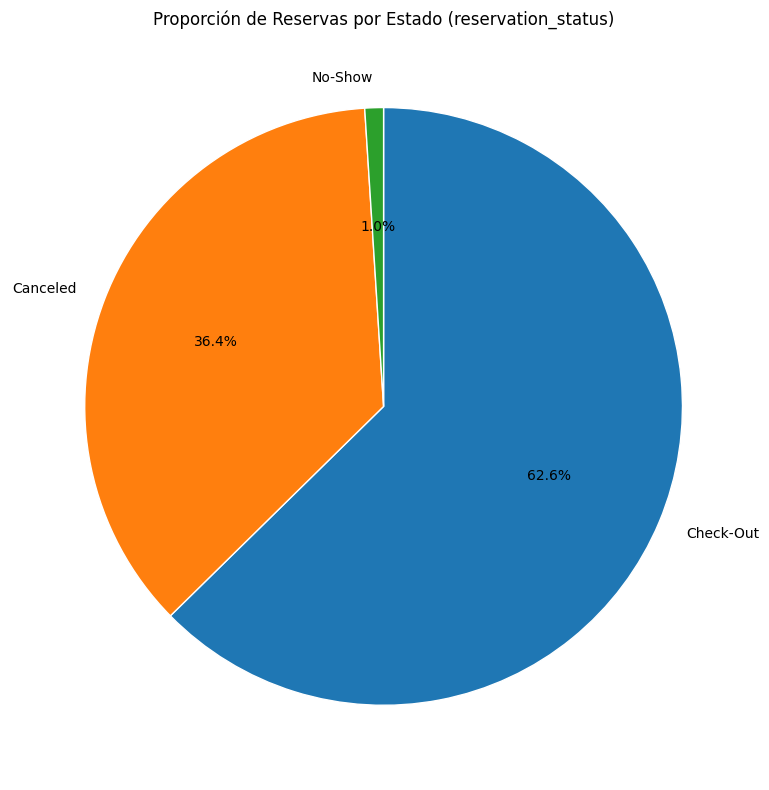

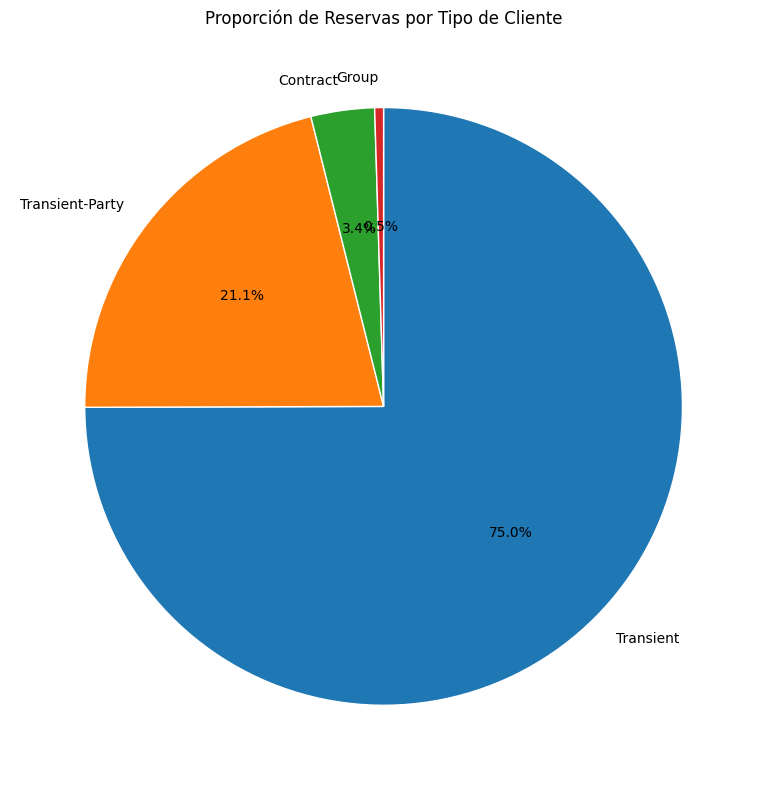

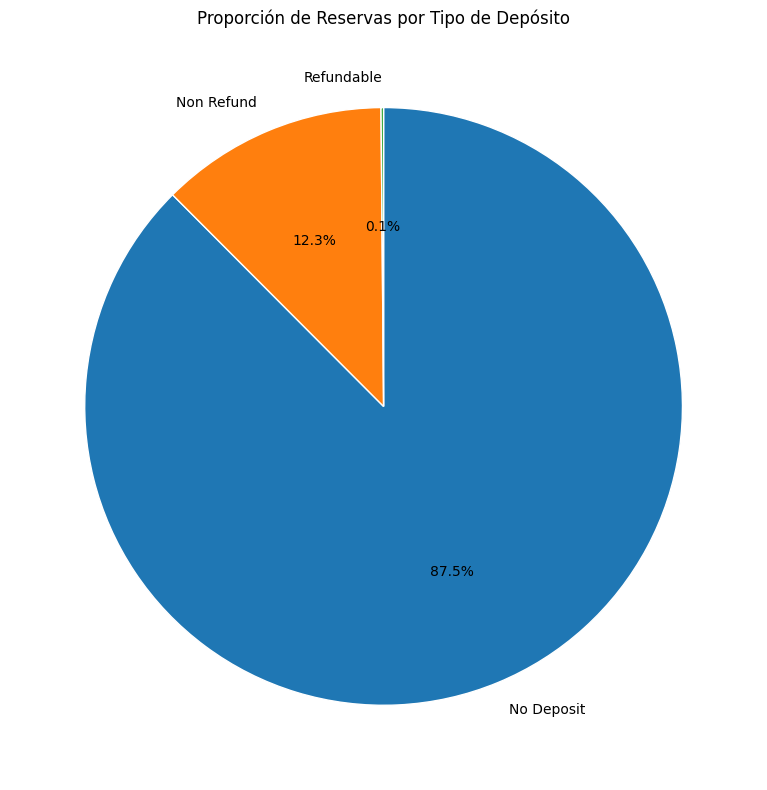

In [19]:
# 1. Conteo de reservation_status
status_counts = df['reservation_status'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Estado (reservation_status)')
plt.tight_layout()
plt.show()

################################################################################

# 2. Conteo de customer_type
type_counts = df['customer_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    type_counts,
    labels=type_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Cliente')
plt.tight_layout()
plt.show()

################################################################################

# 2. Conteo de deposit_type
deposit_counts = df['deposit_type'].value_counts()

# 3. Gráfico de tarta
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    deposit_counts,
    labels=deposit_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False,
    wedgeprops={'edgecolor': 'white'}
)

# 4. Estilo y título
ax.set_title('Proporción de Reservas por Tipo de Depósito')
plt.tight_layout()
plt.show()


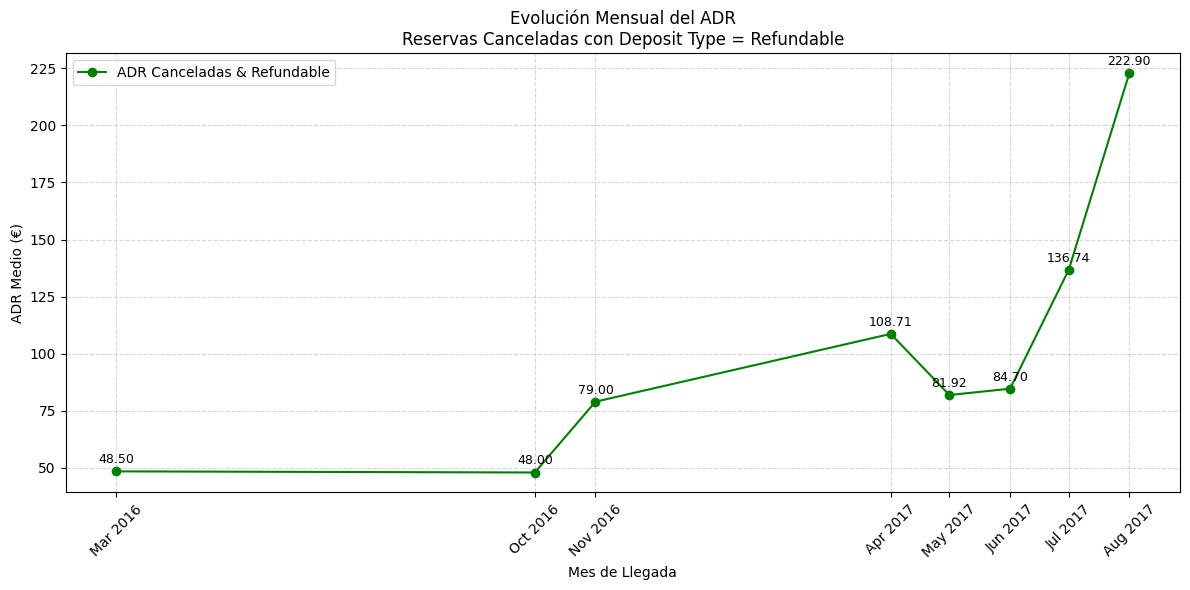

In [20]:
# 2. Filtrar solo las reservas canceladas con deposit_type "Refundable"
mask = (df['is_canceled'] == 1) & (df['deposit_type'] == 'Refundable')
df_refund_cancel = df[mask].copy()

# 3. Agrupar por mes y calcular ADR medio
adr_refund_cancel = (
    df_refund_cancel
      .groupby(df_refund_cancel['arrival_date'].dt.to_period('M'), observed=False)
      .agg(adr_mean=('adr', 'mean'))
      .reset_index()
)
adr_refund_cancel['month'] = adr_refund_cancel['arrival_date'].dt.to_timestamp()

# 4. Graficar la evolución del ADR
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    adr_refund_cancel['month'],
    adr_refund_cancel['adr_mean'],
    marker='o',
    color='green',
    label='ADR Canceladas & Refundable'
)

# 5. Añadir etiquetas de datos encima de cada punto
max_adr = adr_refund_cancel['adr_mean'].max()
for x, y in zip(adr_refund_cancel['month'], adr_refund_cancel['adr_mean']):
    ax.text(
        x, y + max_adr * 0.01,
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 6. Estilo y etiquetas
ax.set_xlabel('Mes de Llegada')
ax.set_ylabel('ADR Medio (€)')
ax.set_title('Evolución Mensual del ADR\nReservas Canceladas con Deposit Type = Refundable')
ax.set_xticks(adr_refund_cancel['month'])
ax.set_xticklabels([d.strftime('%b %Y') for d in adr_refund_cancel['month']], rotation=45)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Análisis bivariante: cancelación vs. otras variables

Variables categóricas

    Segmento de cliente (market_segment), tipo de hotel (hotel), tipo de cliente (customer_type), depósito (deposit_type).

    Cruza cada variable con is_canceled y calcula tasas; visualiza con barras apiladas o mosaicos.

    Test de chi-cuadrado en cada cruce.

Variables numéricas

    lead_time, adr (tarifa diaria), stays_in_weekend_nights, etc.

    Boxplots de cada variable separados por canceled=True/False.

    Correlación de punto biserial o U de Mann–Whitney para ver si los distribuciones difieren.

### Variables categóricas


=== Variable: market_segment ===



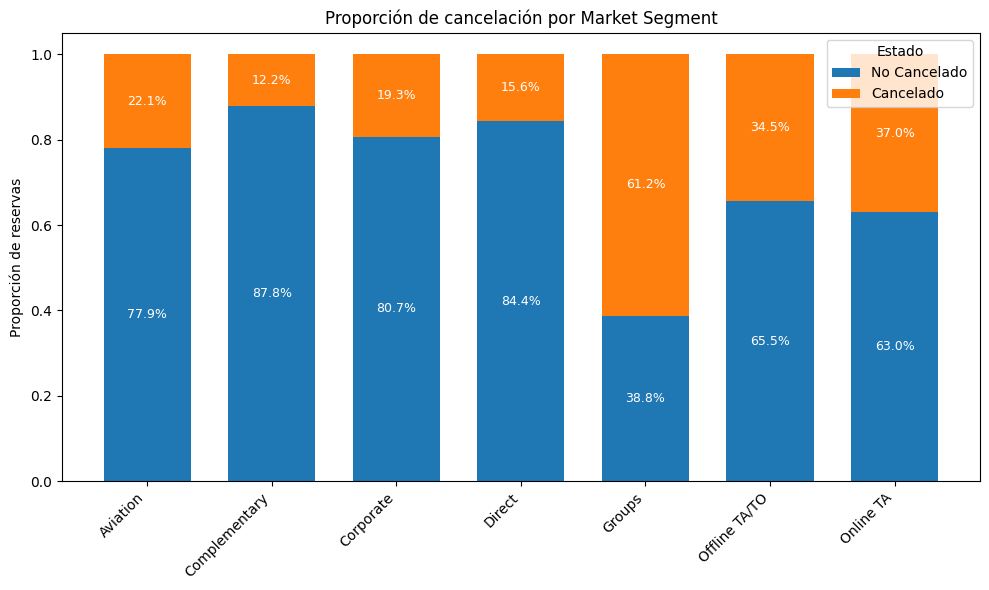

Chi² = 8302.35, p-valor = 0.0000 → Significativo


=== Variable: hotel ===



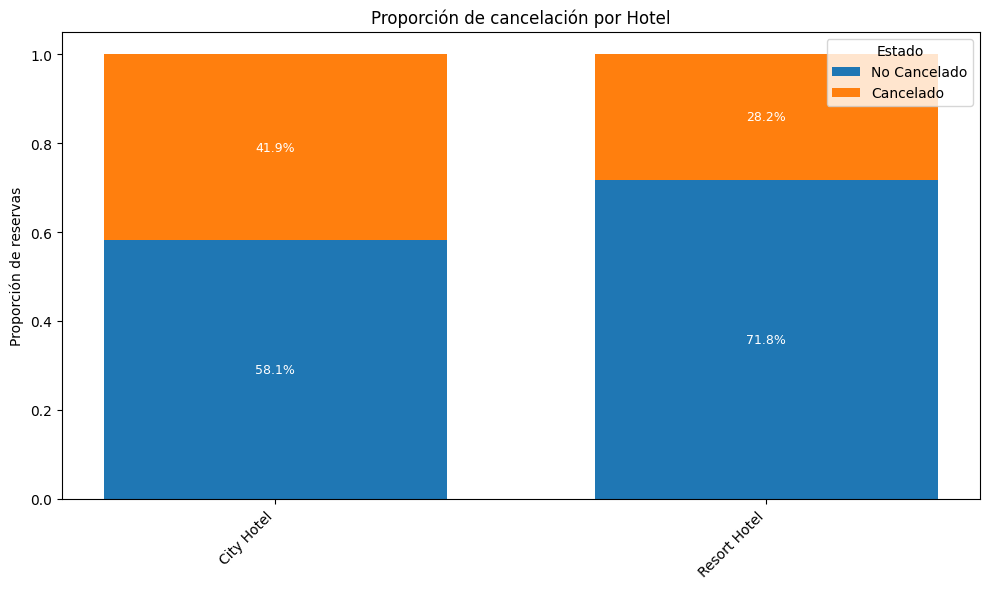

Chi² = 2091.00, p-valor = 0.0000 → Significativo


=== Variable: customer_type ===



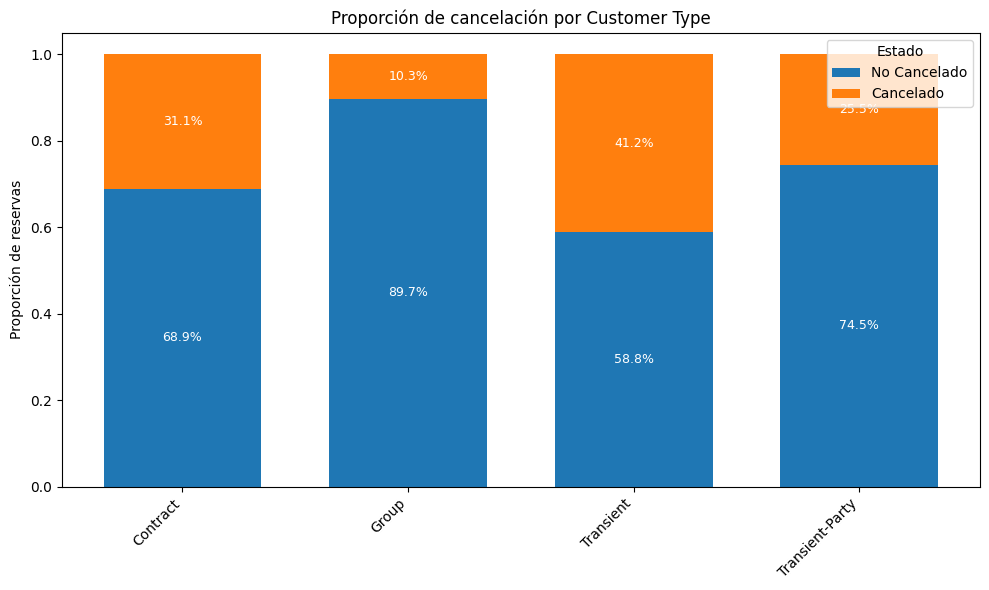

Chi² = 2286.54, p-valor = 0.0000 → Significativo


=== Variable: deposit_type ===



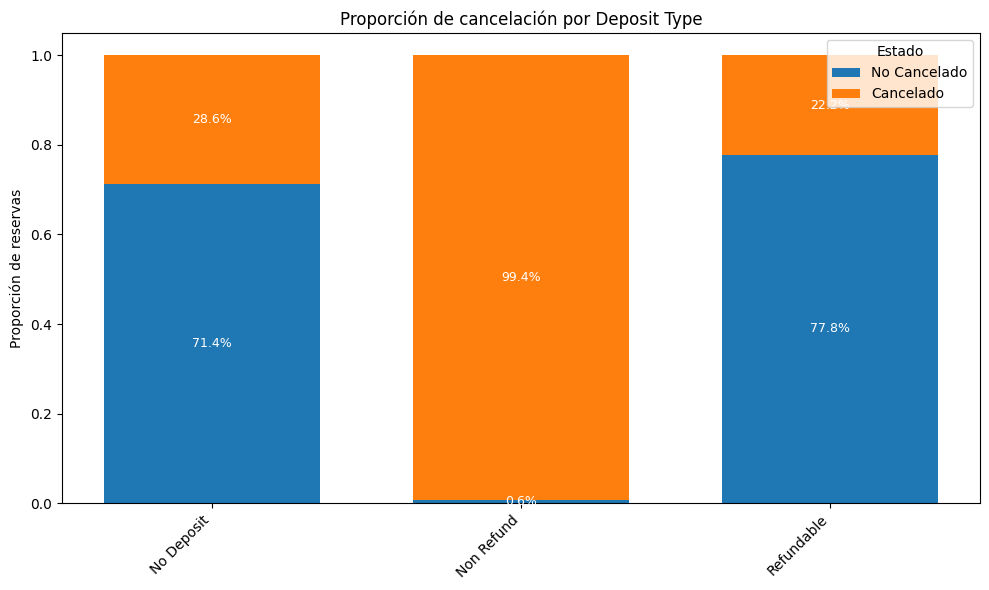

Chi² = 27312.75, p-valor = 0.0000 → Significativo



In [24]:
# 4.1 Análisis bivariante: cancelación vs. variables categóricas

# 0) Carga del CSV y mapeo de la columna de cancelación a texto

df['cancel_label'] = df['is_canceled'].map({False: 'No Cancelado', True: 'Cancelado'})

categorical_vars = ['market_segment', 'hotel', 'customer_type', 'deposit_type']

for var in categorical_vars:
    print(f"\n=== Variable: {var} ===\n")
    
    # 1) Crosstab usando la etiqueta de texto
    ct = pd.crosstab(df[var], df['cancel_label'])
    
    # 2) Proporciones por fila
    ct_prop = ct.div(ct.sum(axis=1), axis=0)
    
    # 3) Gráfico de barras apiladas manual con etiquetas de porcentaje
    labels    = ct_prop.index.tolist()
    no_cancel = ct_prop['No Cancelado'].values
    cancel    = ct_prop['Cancelado'].values
    x         = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x, no_cancel, width=0.7, label='No Cancelado')
    ax.bar(x, cancel,    width=0.7, bottom=no_cancel, label='Cancelado')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Proporción de reservas')
    ax.set_title(f'Proporción de cancelación por {var.replace("_", " ").title()}')
    ax.legend(title='Estado', loc='upper right')
    
    # Añadir etiqueta de porcentaje en cada segmento
    for i in range(len(x)):
        if no_cancel[i] > 0:
            ax.text(x[i], no_cancel[i] / 2,
                    f"{no_cancel[i]:.1%}",
                    ha='center', va='center', fontsize=9, color='white')
        if cancel[i] > 0:
            ax.text(x[i], no_cancel[i] + cancel[i] / 2,
                    f"{cancel[i]:.1%}",
                    ha='center', va='center', fontsize=9, color='white')
    plt.tight_layout()
    plt.show()
    
    # 5) Test de chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"Chi² = {chi2:.2f}, p-valor = {p:.4f} → "
          + ("Significativo" if p < 0.05 else "No significativo") + "\n")


Counts after filter: {False: 22918, True: 15123}


/tmp/ipykernel_46655/679178708.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = [counts.get(0, 0), counts.get(1, 0)]


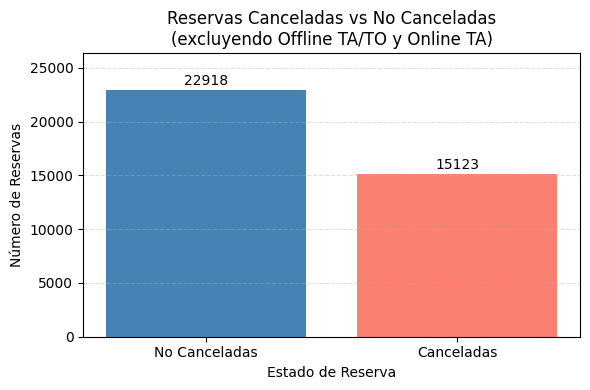

In [25]:
# 2. Filtrar excluyendo ciertos market_segment
exclude = ['Offline TA/TO', 'Online TA']
df_f = df[~df['market_segment'].isin(exclude)].copy()

# 3. Contar canceladas y no canceladas
counts = df_f['is_canceled'].value_counts().sort_index()
print("Counts after filter:", counts.to_dict())

# 4. Preparar etiquetas y valores
labels = ['No Canceladas', 'Canceladas']
values = [counts.get(0, 0), counts.get(1, 0)]

# 5. Dibujo del bar chart
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, values, color=['steelblue', 'salmon'])

# 6. Anotar cada barra
max_val = max(values)
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max_val * 0.01,
        f"{int(h)}",
        ha='center', va='bottom',
        fontsize=10
    )

# 7. Etiquetas y estilo
ax.set_title('Reservas Canceladas vs No Canceladas\n(excluyendo Offline TA/TO y Online TA)')
ax.set_xlabel('Estado de Reserva')
ax.set_ylabel('Número de Reservas')
ax.set_ylim(0, max_val * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

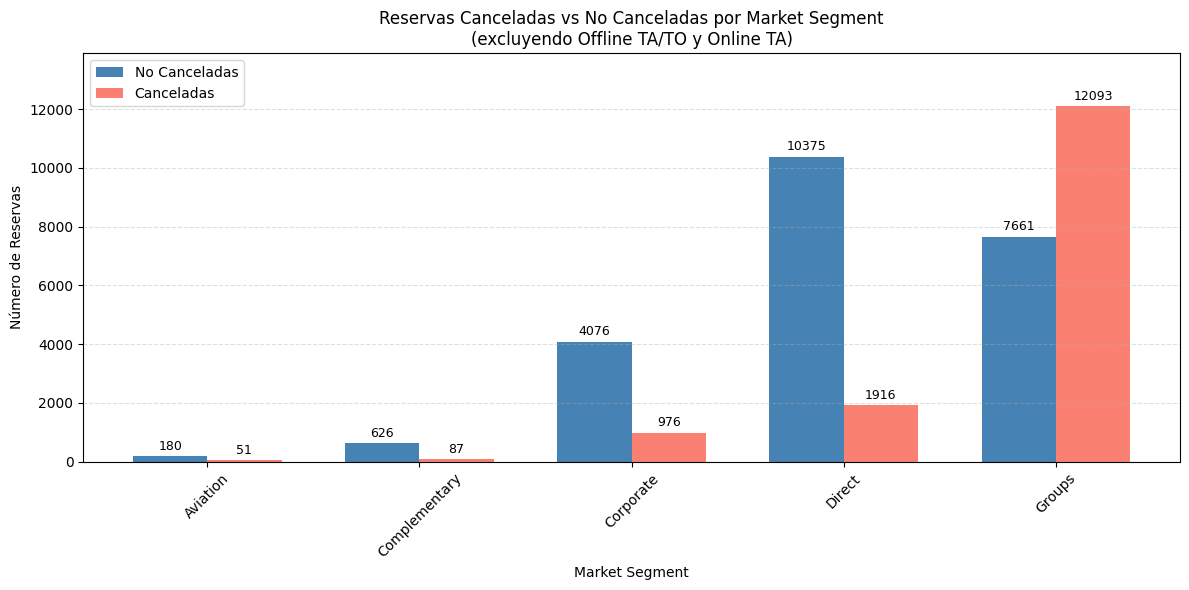

In [26]:
# 2. Filtrar excluyendo Offline TA/TO y Online TA
exclude_segments = ['Offline TA/TO', 'Online TA']
df_f = df[~df['market_segment'].isin(exclude_segments)].copy()

# 3. Contar reservas por market_segment y estado de cancelación
counts = (
    df_f
    .groupby(['market_segment', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'No Canceladas', 1: 'Canceladas'})
    .reset_index()
)

# 4. Preparar posiciones y anchuras
n_segments = len(counts)
x = np.arange(n_segments)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# 5. Dibujar barras side-by-side
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 6. Anotar valores encima de cada barra
max_height = counts[['No Canceladas','Canceladas']].values.max()
for bar in list(bars_no) + list(bars_yes):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max_height*0.01,
        f"{int(h)}",
        ha='center', va='bottom',
        fontsize=9
    )

# 7. Etiquetas y estilo
ax.set_xlabel('Market Segment')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas Canceladas vs No Canceladas por Market Segment\n(excluyendo Offline TA/TO y Online TA)')
ax.set_xticks(x)
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [91]:
# Ajustes opcionales de estilo
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

# %%

# Aseguramos datetime
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Creamos duración total de estancia si no existiera
if 'total_length_of_stay' not in df.columns:
    df['total_length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']


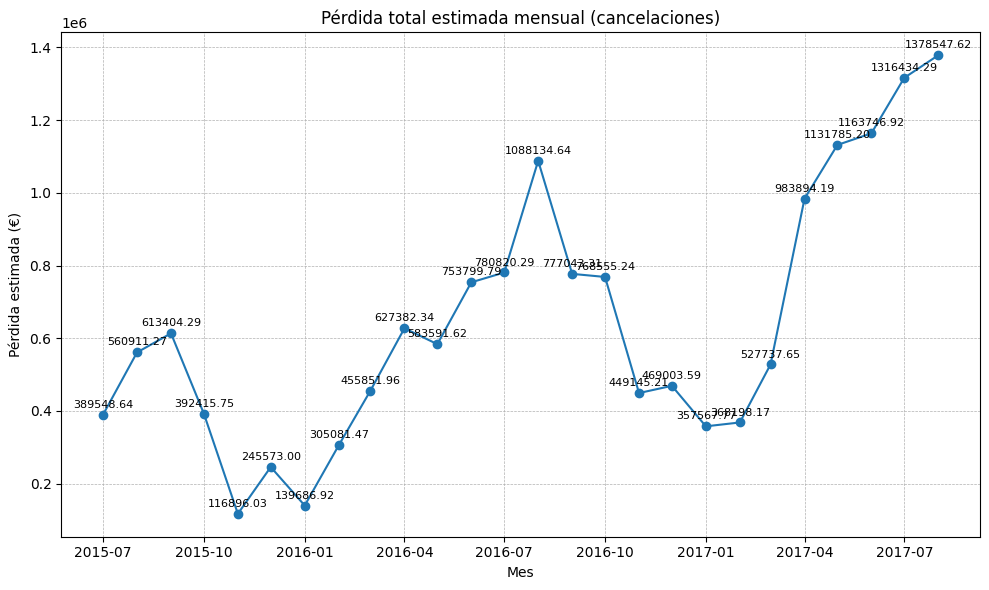

In [93]:
# ## 2. Pérdida total mensual por cancelaciones

# %%
# Filtramos canceladas y calculamos pérdida por reserva
df_canc = df[df['is_canceled'] == True].copy()
df_canc['loss'] = df_canc['adr'] * df_canc['total_length_of_stay']

# Agrupamos y sumamos por mes-año
monthly_loss = (
    df_canc
    .groupby(df_canc['arrival_date'].dt.to_period('M'))['loss']
    .sum()
    .to_timestamp()
)

# %%
# Gráfico de línea
fig, ax = plt.subplots()
ax.plot(monthly_loss.index, monthly_loss.values, marker='o')
ax.set_title('Pérdida total estimada mensual (cancelaciones)')
ax.set_xlabel('Mes')
ax.set_ylabel('Pérdida estimada (€)')
ax.grid(True, linestyle='--', linewidth=0.5)

# Anotamos cada punto
for x, y in zip(monthly_loss.index, monthly_loss.values):
    ax.annotate(f"{y:.2f}", (x, y),
                textcoords="offset points", xytext=(0,5),
                ha='center', fontsize=8)
plt.tight_layout()
plt.show()

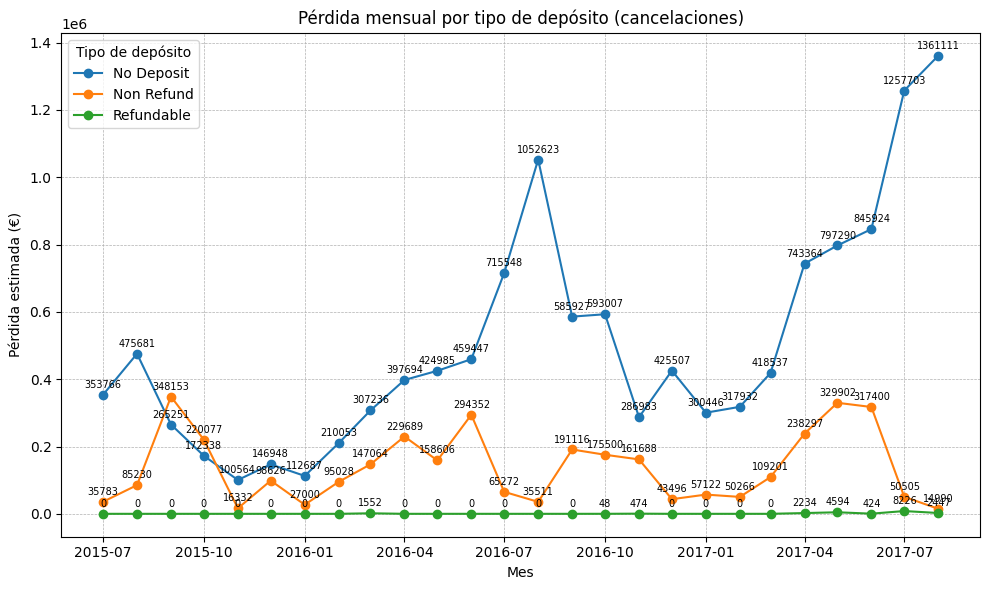

In [29]:
# %% [markdown]
# ## 3. Pérdida mensual desglosada por tipo de depósito

# %%
# Aseguramos etiqueta de depósito
df_canc['deposit_type'] = df_canc['deposit_type'].astype(str)

# Agrupamos por mes y deposit_type
monthly_loss_dep = (
    df_canc
    .groupby([df_canc['arrival_date'].dt.to_period('M'), 'deposit_type'])['loss']
    .sum()
    .unstack('deposit_type')
    .fillna(0)
    .to_timestamp()
)

# %%
# Gráfico de línea por depósito
fig, ax = plt.subplots()
for dep in monthly_loss_dep.columns:
    ax.plot(monthly_loss_dep.index, monthly_loss_dep[dep],
            marker='o', label=dep)
ax.set_title('Pérdida mensual por tipo de depósito (cancelaciones)')
ax.set_xlabel('Mes')
ax.set_ylabel('Pérdida estimada (€)')
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend(title='Tipo de depósito')

# Anotamos cada punto por curva
for dep in monthly_loss_dep.columns:
    for x, y in zip(monthly_loss_dep.index, monthly_loss_dep[dep]):
        ax.annotate(f"{y:.0f}", (x, y),
                    textcoords="offset points", xytext=(0,5),
                    ha='center', fontsize=7)
plt.tight_layout()
plt.show()


In [30]:
# Código para realizar los tests uno por uno

df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['mes'] = df['arrival_date'].dt.month
# Calculamos la tasa de cancelación mensual para regresión
monthly_rate = df.groupby('mes')['is_canceled'].mean()

# 1) Chi‑cuadrado de independencia (mes × cancelación)
ct = pd.crosstab(df['mes'], df['is_canceled'])
chi2, p_chi, dof, expected = stats.chi2_contingency(ct)
print("=== Chi‑cuadrado de independencia ===")
print(f"Chi2 = {chi2:.2f}, p‑valor = {p_chi:.4f}\n")

# 2) ANOVA unifactorial sobre tasa de cancelación
groups = [grp['is_canceled'].values for _, grp in df.groupby('mes')]
f_stat, p_anova = stats.f_oneway(*groups)
print("=== ANOVA unifactorial ===")
print(f"F = {f_stat:.2f}, p‑valor = {p_anova:.4f}\n")

# 3) Prueba de tendencia: Kendall Tau
#tau, p_tau = stats.kendalltau(monthly_rate.index, monthly_rate.values)
#print("=== Tendencia (Kendall Tau) ===")
#print(f"Tau = {tau:.3f}, p‑valor = {p_tau:.4f}\n")

# 4) Regresión lineal simple sobre tasa vs. mes
X = sm.add_constant(monthly_rate.index)
model = sm.OLS(monthly_rate.values, X).fit()
print("=== Regresión lineal sobre tasa vs. mes ===")
print(model.summary())


=== Chi‑cuadrado de independencia ===
Chi2 = 542.76, p‑valor = 0.0000

=== ANOVA unifactorial ===
F = 49.56, p‑valor = 0.0000

=== Regresión lineal sobre tasa vs. mes ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3627
Date:                Fri, 02 May 2025   Prob (F-statistic):              0.560
Time:                        14:32:02   Log-Likelihood:                 23.319
No. Observations:                  12   AIC:                            -42.64
Df Residuals:                      10   BIC:                            -41.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err       

/home/reboot-student/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  res = hypotest_fun_out(*samples, **kwds)


In [31]:
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['mes'] = df['arrival_date'].dt.month

# 2) Tasa mensual de cancelación
monthly_rate = df.groupby('mes')['is_canceled'].mean()

# 3) Chi-cuadrado mes × cancelación
ct = pd.crosstab(df['mes'], df['is_canceled'])
chi2, p_chi, dof, exp = stats.chi2_contingency(ct)
print("Chi2 test:", chi2, "p-valor:", p_chi)

# 4) ANOVA unifactorial
groups = [g['is_canceled'].values for _, g in df.groupby('mes')]
F, p_anova = stats.f_oneway(*groups)
print("ANOVA F-stat:", F, "p-valor:", p_anova)

# 5) Prueba de tendencia (Kendall)
tau, p_tau = stats.kendalltau(monthly_rate.index, monthly_rate.values)
print("Kendall Tau:", tau, "p-valor:", p_tau)

# 6) Regresión lineal de tasa vs mes
X = sm.add_constant(monthly_rate.index)
model = sm.OLS(monthly_rate.values, X).fit()

#  ——> Aquí filtramos el warning de kurtosistest:
warnings.filterwarnings(
    "ignore",
    message=".*kurtosistest only valid for n>=20.*",
    category=UserWarning
)

print(model.summary())


Chi2 test: 542.7641641398702 p-valor: 2.3974650825962615e-109
ANOVA F-stat: 49.564998561134935 p-valor: 1.3180254277582658e-109
Kendall Tau: 0.0606060606060606 p-valor: 0.8405883696421891
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.3627
Date:                Fri, 02 May 2025   Prob (F-statistic):              0.560
Time:                        14:32:02   Log-Likelihood:                 23.319
No. Observations:                  12   AIC:                            -42.64
Df Residuals:                      10   BIC:                            -41.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

A partir de los resultados:

    Chi-cuadrado de independencia

        Estadístico: χ² = 542.76, p-valor < 0.0001

        Interpretación: Rechazamos la H₀ (“la probabilidad de cancelación es la misma en todos los meses”). Hay evidencia muy fuerte de que el mes del año y la probabilidad de cancelación están asociados.

    ANOVA unifactorial

        F = 49.56, p-valor < 0.0001

        Interpretación: También aquí rechazamos la H₀ (“las medias de la tasa de cancelación son iguales para todos los meses”). Los promedios de cancelación difieren significativamente entre meses.

    Tendencia (Kendall Tau)

        Tau = 0.061, p-valor = 0.8406

        Interpretación: No hay evidencia de una tendencia monótona (ni creciente ni decreciente) en la tasa de cancelación a lo largo del año.

    Regresión lineal tasa vs. mes

        Intercepto ≈ 0.355 (p<0.001)

        Pendiente ≈ 0.0019 (p = 0.56)

        R² ≈ 0.035

        Interpretación: El coeficiente de mes no es significativo (p=0.56), confirmando que no existe una tendencia lineal clara en la tasa de cancelación a lo largo de los meses.

#### Conclusión global
#### Hay variación estacional: ciertas épocas del año tienen cancelaciones muy distintas (Chi-cuadrado y ANOVA lo confirman).
#### Sin embargo, no existe una tendencia lineal ni monótona de aumento o disminución de cancelaciones mes a mes durante el período analizado.
#### En la práctica: deberías centrarte en identificar meses pico y quizá investigar qué factores (vacaciones, temporada alta, políticas de precios) explican esas diferencias estacionales, más que buscar un patrón de crecimiento o decrecimiento a lo largo del tiempo.

Incentivar reservas last-minute (
    coste medio o % de lo que se deberia cobrar si cancela

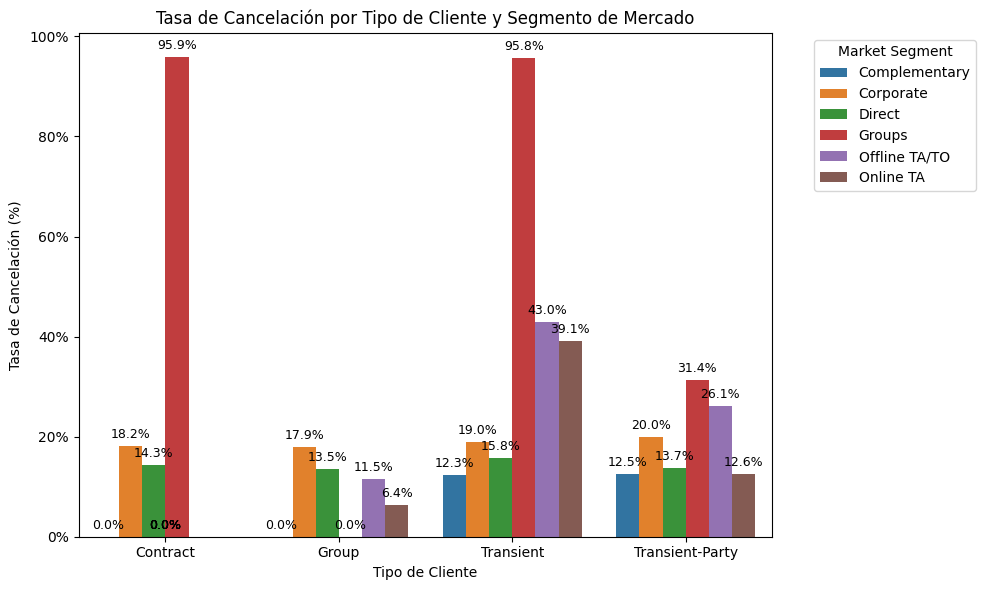

In [49]:
# 2. Agrupar por customer_type y market_segment
summary = (
    df
    .groupby(['customer_type', 'market_segment'], observed=False)
    .agg(
        total_reservas=('is_canceled', 'size'),
        cancelaciones=('is_canceled', 'sum'),
        tasa_cancelacion=('is_canceled', 'mean')
    )
    .reset_index()
)

# 3. Gráfico de barras con seaborn
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=summary,
    x='customer_type',
    y='tasa_cancelacion',
    hue='market_segment',
    ax=ax
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylabel('Tasa de Cancelación (%)')

# 5. Añadir etiquetas de datos en cada barra
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax.text(
        x, 
        height + 0.01, 
        f"{height*100:.1f}%", 
        ha='center', 
        va='bottom',
        fontsize=9
    )

# 6. Ajustes finales
ax.set_xlabel('Tipo de Cliente')
ax.set_title('Tasa de Cancelación por Tipo de Cliente y Segmento de Mercado')
plt.xticks(rotation=0)
plt.legend(title='Market Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

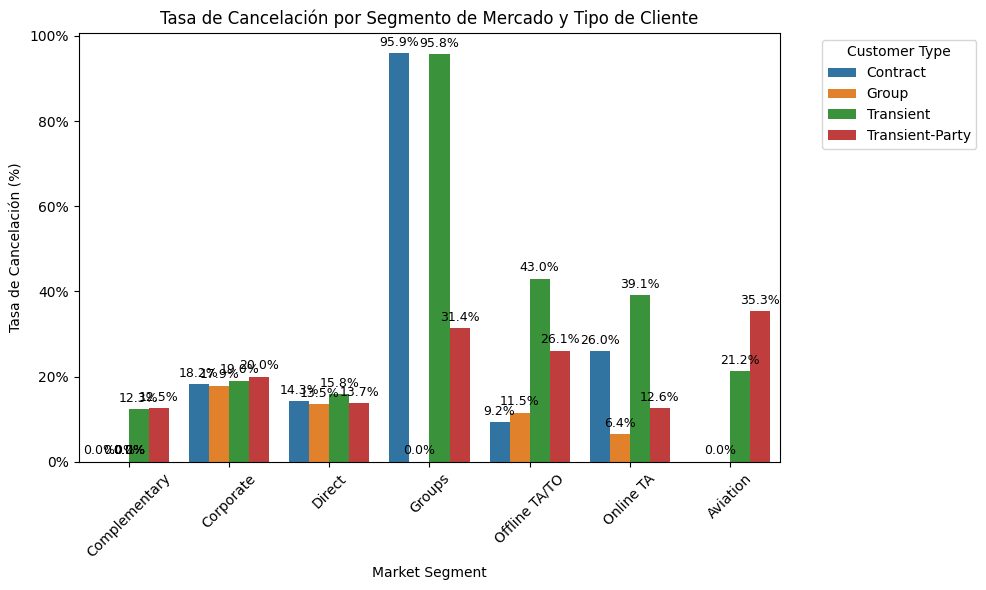

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# 1. Carga del dataset
df = pd.read_csv('hotel_bookings_clean.csv')

# 2. Agrupar por customer_type y market_segment
summary = (
    df
    .groupby(['customer_type', 'market_segment'], observed=False)
    .agg(
        total_reservas=('is_canceled', 'size'),
        cancelaciones=('is_canceled', 'sum'),
        tasa_cancelacion=('is_canceled', 'mean')
    )
    .reset_index()
)

# 3. Gráfico de barras intercambiando customer_type y market_segment
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=summary,
    x='market_segment',        # ahora el eje X es market_segment
    y='tasa_cancelacion',
    hue='customer_type',       # y cada barra se hue por customer_type
    ax=ax
)

# 4. Formatear eje Y como porcentaje
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_ylabel('Tasa de Cancelación (%)')
ax.set_xlabel('Market Segment')

# 5. Añadir etiquetas de datos en cada barra
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax.text(
        x, 
        height + 0.01, 
        f"{height*100:.1f}%", 
        ha='center', 
        va='bottom',
        fontsize=9
    )

# 6. Ajustes finales
ax.set_title('Tasa de Cancelación por Segmento de Mercado y Tipo de Cliente')
plt.xticks(rotation=45)
plt.legend(title='Customer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_46655/3276742668.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



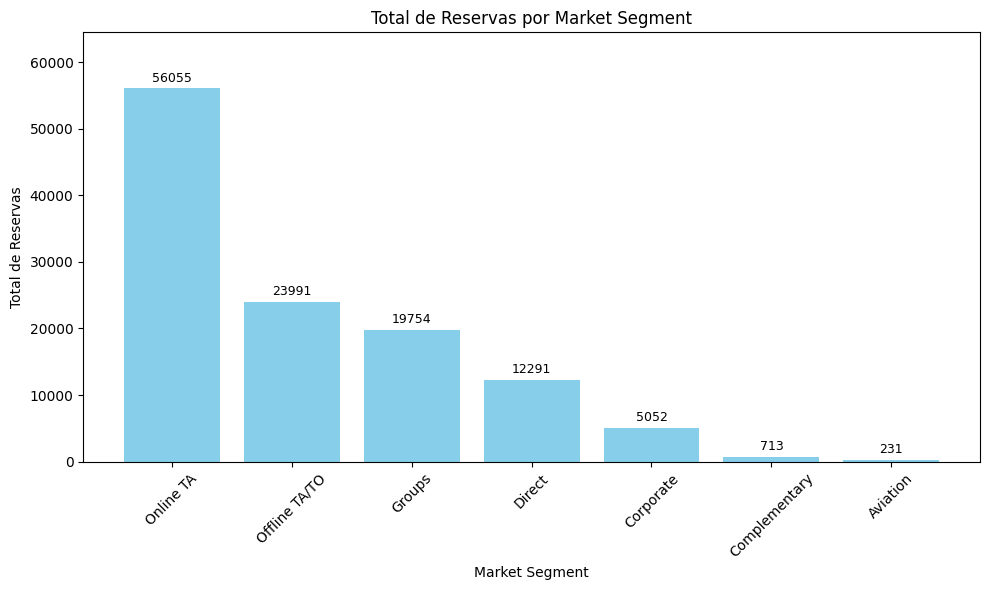

In [96]:
# 2. Contar reservas por market_segment
counts = (
    df
    .groupby('market_segment', observed=False)
    .size()
    .reset_index(name='total_reservations')
    .sort_values('total_reservations', ascending=False)
)

# 3. Gráfico de barras con Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    counts['market_segment'],
    counts['total_reservations'],
    color='skyblue'
)

# 4. Anotar valores encima de cada barra
max_val = counts['total_reservations'].max()
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + max_val*0.01,
        f"{height}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 5. Etiquetas y estilo
ax.set_title('Total de Reservas por Market Segment')
ax.set_xlabel('Market Segment')
ax.set_ylabel('Total de Reservas')
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.set_ylim(0, max_val * 1.15)
plt.tight_layout()
plt.show()


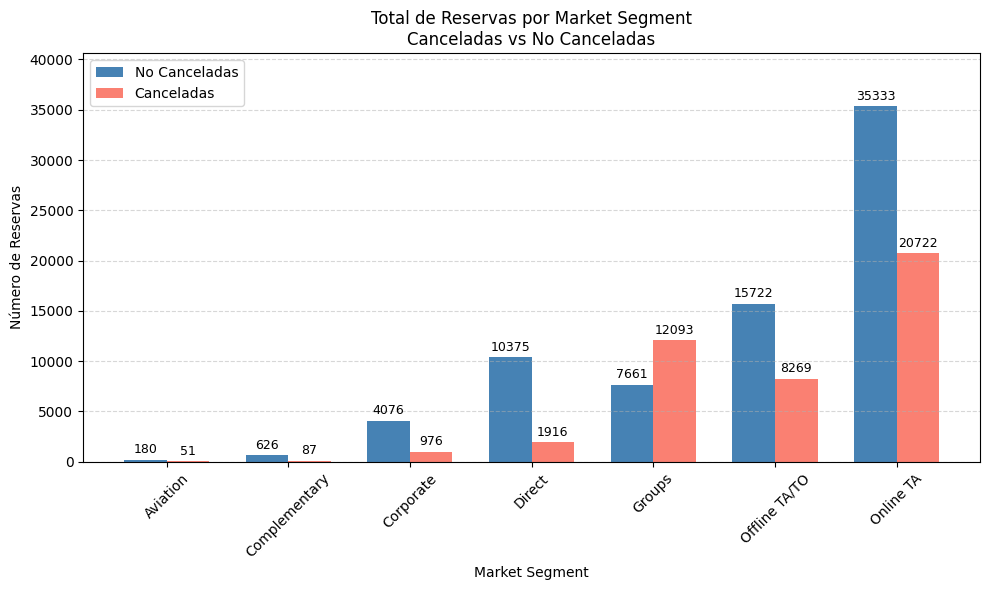

In [104]:
# 2. Conteo de reservas por market_segment y estado de cancelación
counts = (
    df
    .groupby(['market_segment', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
)
# Renombrar columnas para legibilidad
counts = counts.rename(columns={0: 'No Canceladas', 1: 'Canceladas'}).reset_index()

# 3. Configuración de posición de barras
x = np.arange(len(counts))           # posición de cada grupo en el eje X
width = 0.35                         # ancho de cada barra

fig, ax = plt.subplots(figsize=(10, 6))

# 4. Dibujar barras
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 5. Anotar valores encima de cada barra
for bar in bars_no + bars_yes:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + counts[['No Canceladas','Canceladas']].values.max() * 0.01,
        f"{int(h)}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 6. Etiquetas y estilo
ax.set_xlabel('Market Segment')
ax.set_ylabel('Número de Reservas')
ax.set_title('Total de Reservas por Market Segment\nCanceladas vs No Canceladas')
ax.set_xticks(x)
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, counts[['No Canceladas','Canceladas']].values.max() * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


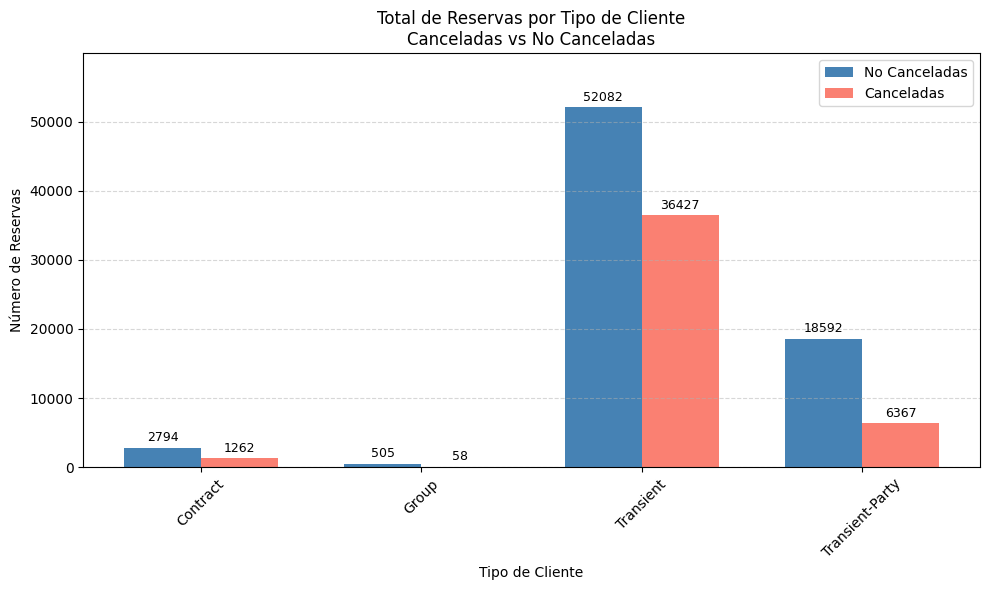

In [100]:
# 2. Conteo de reservas por customer_type y estado de cancelación
counts = (
    df
    .groupby(['customer_type', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
)
# Renombrar columnas para legibilidad
counts = counts.rename(columns={0: 'No Canceladas', 1: 'Canceladas'}).reset_index()

# 3. Configuración de posiciones en el eje X
x = np.arange(len(counts))   # posiciones para cada customer_type
width = 0.35                 # ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# 4. Dibujar barras side-by-side
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 5. Anotar valores encima de cada barra
max_height = counts[['No Canceladas','Canceladas']].values.max()
for bar in list(bars_no) + list(bars_yes):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max_height * 0.01,
        f"{int(h)}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# 6. Etiquetas y estilo
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Número de Reservas')
ax.set_title('Total de Reservas por Tipo de Cliente\nCanceladas vs No Canceladas')
ax.set_xticks(x)
ax.set_xticklabels(counts['customer_type'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


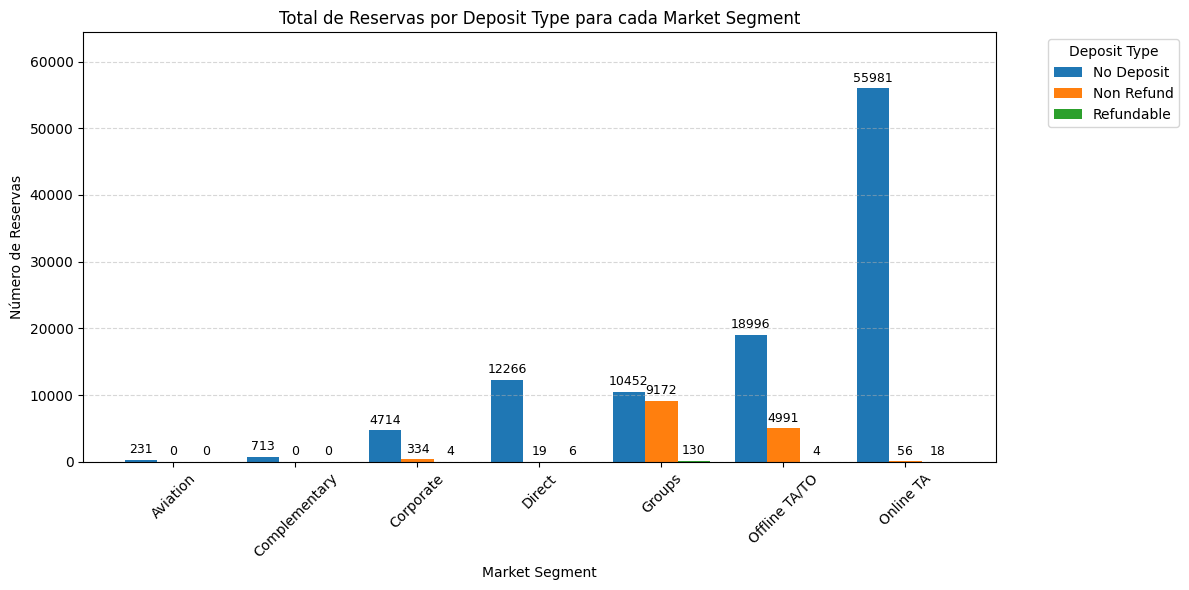

In [102]:


# 2. Conteo de reservas por market_segment y deposit_type
counts = (
    df
    .groupby(['market_segment', 'deposit_type'], observed=False)
    .size()
    .unstack(fill_value=0)
)
# Reset para usar en Matplotlib
counts = counts.reset_index()
deposit_types = counts.columns.drop('market_segment')

# 3. Configuración de posiciones
x = np.arange(len(counts))      # posiciones para cada market_segment
width = 0.8 / len(deposit_types)  # ancho de barra según número de deposit_type

fig, ax = plt.subplots(figsize=(12, 6))

# 4. Dibujar barras para cada deposit_type
for i, dtype in enumerate(deposit_types):
    ax.bar(
        x + i*width - (width*(len(deposit_types)-1)/2),
        counts[dtype],
        width,
        label=dtype
    )

# 5. Anotar valores encima de cada barra
max_height = counts[deposit_types].values.max()
for i, row in counts.iterrows():
    for j, dtype in enumerate(deposit_types):
        height = row[dtype]
        ax.text(
            x[i] + j*width - (width*(len(deposit_types)-1)/2),
            height + max_height*0.01,
            f"{int(height)}",
            ha='center',
            va='bottom',
            fontsize=9
        )

# 6. Etiquetas y estilo
ax.set_xlabel('Market Segment')
ax.set_ylabel('Número de Reservas')
ax.set_title('Total de Reservas por Deposit Type para cada Market Segment')
ax.set_xticks(x)
ax.set_xticklabels(counts['market_segment'], rotation=45)
ax.legend(title='Deposit Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Reservas canceladas vs No canceladas por tipo de cliente

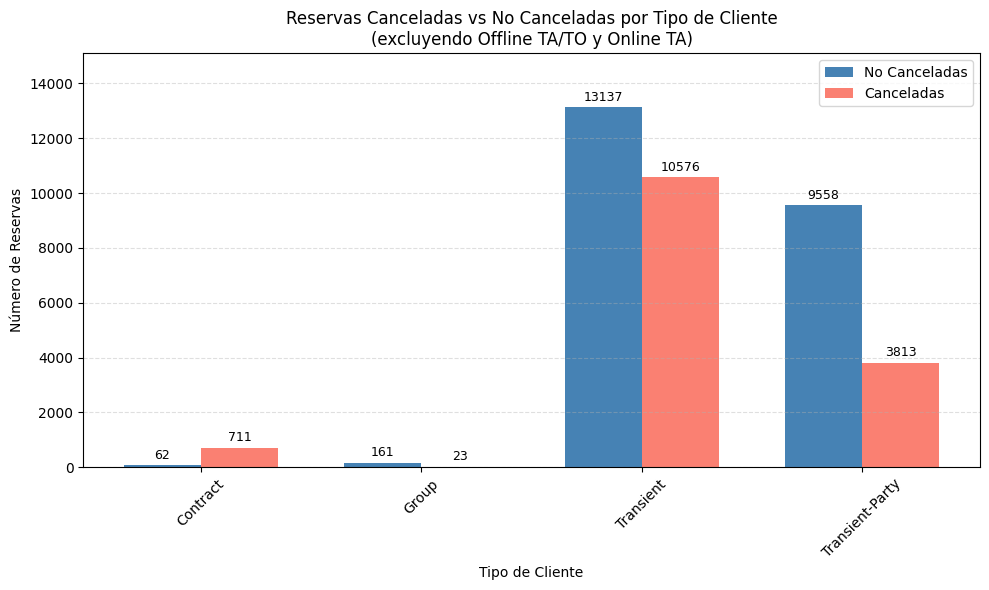

In [106]:
# 2. Filtrar excluyendo Offline TA/TO y Online TA
exclude_segments = ['Offline TA/TO', 'Online TA']
df_f = df[~df['market_segment'].isin(exclude_segments)].copy()

# 3. Agrupar por customer_type y estado de cancelación
counts = (
    df_f
    .groupby(['customer_type', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'No Canceladas', 1: 'Canceladas'})
    .reset_index()
)

# 4. Configurar posiciones
n_types = len(counts)
x = np.arange(n_types)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# 5. Dibujar barras side-by-side
bars_no = ax.bar(
    x - width/2,
    counts['No Canceladas'],
    width,
    label='No Canceladas',
    color='steelblue'
)
bars_yes = ax.bar(
    x + width/2,
    counts['Canceladas'],
    width,
    label='Canceladas',
    color='salmon'
)

# 6. Anotar valores encima de cada barra
max_h = counts[['No Canceladas','Canceladas']].values.max()
for bar in list(bars_no) + list(bars_yes):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max_h * 0.01,
        f"{int(h)}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# 7. Etiquetas y estilo
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas Canceladas vs No Canceladas por Tipo de Cliente\n(excluyendo Offline TA/TO y Online TA)')
ax.set_xticks(x)
ax.set_xticklabels(counts['customer_type'], rotation=45)
ax.legend(title='')
ax.set_ylim(0, max_h * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


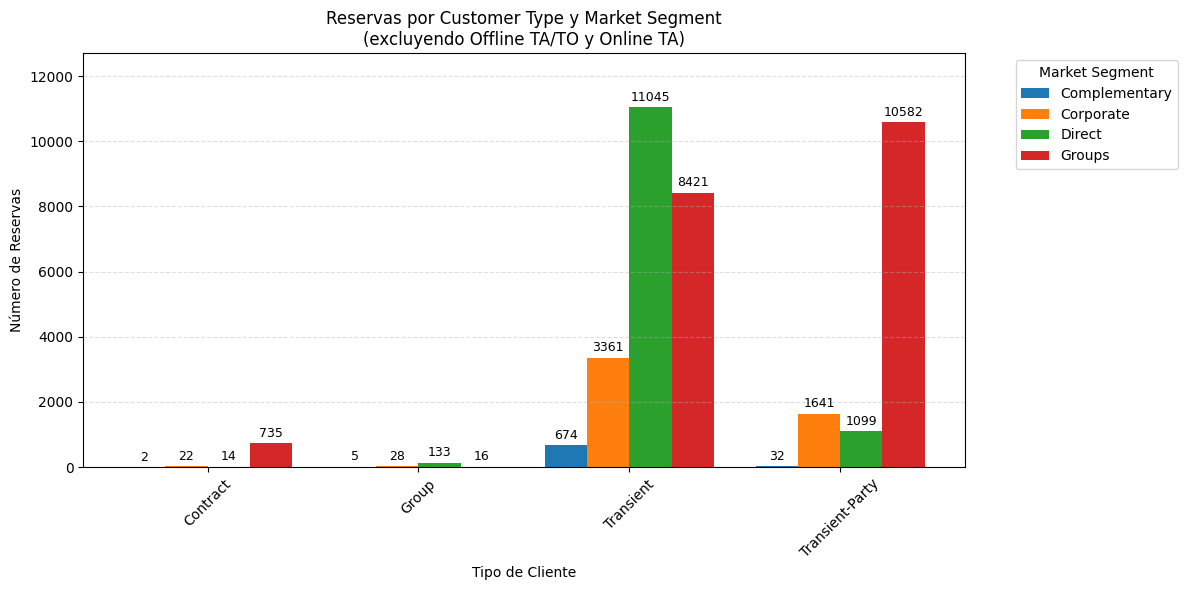

In [52]:
# 2. Filtrar excluyendo Offline TA/TO y Online TA
exclude_segments = ['Offline TA/TO', 'Online TA']
df_f = df[~df['market_segment'].isin(exclude_segments)].copy()

# 3. Contar reservas por customer_type y market_segment
counts = (
    df_f
    .groupby(['customer_type', 'market_segment'], observed=False)
    .size()
    .unstack(fill_value=0)
)

# 4. Preparar los índices y offsets
customer_types   = counts.index.tolist()
market_segments  = counts.columns.tolist()
n_types          = len(customer_types)
n_segments       = len(market_segments)
x                = np.arange(n_types)
width            = 0.8 / n_segments  # 80% del espacio dividido en n_segments barras

# 5. Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 6))

for j, ms in enumerate(market_segments):
    ax.bar(
        x + (j - (n_segments-1)/2) * width,
        counts[ms],
        width,
        label=ms
    )

# 6. Anotar valores encima de cada barra
max_height = counts.values.max()
for i, ct in enumerate(customer_types):
    for j, ms in enumerate(market_segments):
        val = counts.loc[ct, ms]
        xpos = x[i] + (j - (n_segments-1)/2) * width
        ax.text(
            xpos,
            val + max_height * 0.01,
            f"{int(val)}",
            ha='center', va='bottom',
            fontsize=9
        )

# 7. Etiquetas y estilo
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Número de Reservas')
ax.set_title('Reservas por Customer Type y Market Segment\n(excluyendo Offline TA/TO y Online TA)')
ax.set_xticks(x)
ax.set_xticklabels(customer_types, rotation=45)
ax.legend(title='Market Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, max_height * 1.15)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


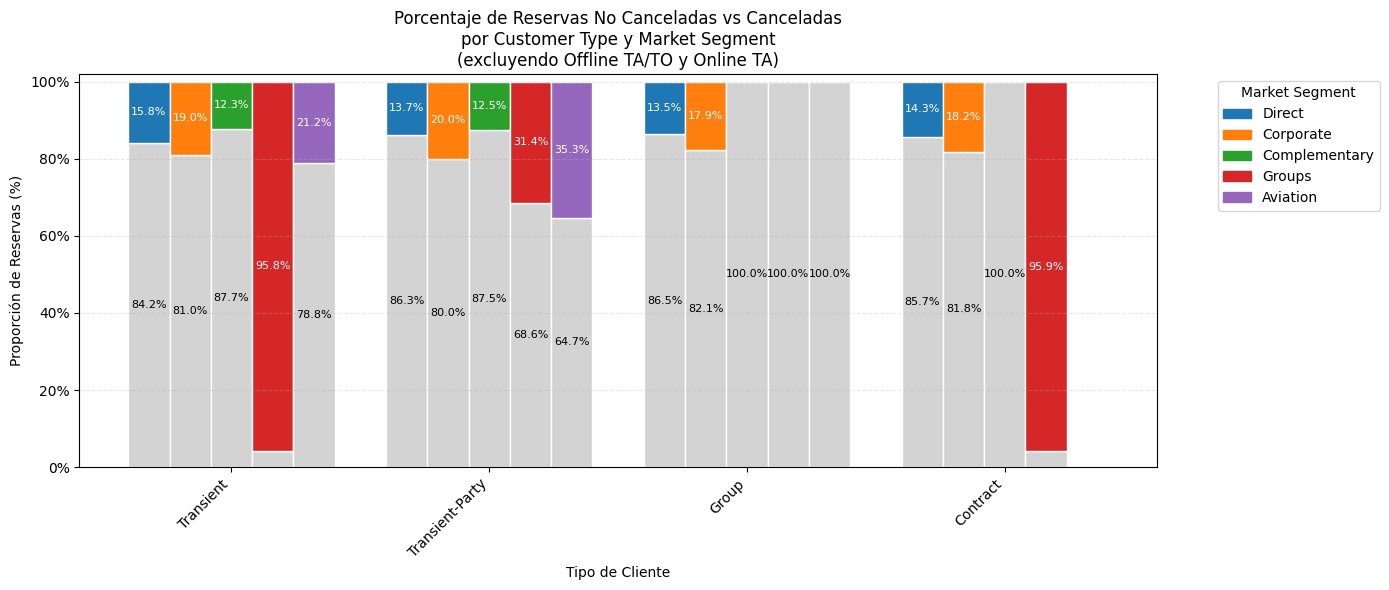

In [58]:
exclude = ['Offline TA/TO', 'Online TA']
df = df[~df['market_segment'].isin(exclude)].copy()

# 2. Agregar conteos
grp = (
    df
    .groupby(['customer_type','market_segment','is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0:'not_canceled',1:'canceled'})
)

# 3. Calcular proporciones
grp['total'] = grp['not_canceled'] + grp['canceled']
grp['p_not'] = grp['not_canceled'] / grp['total']
grp['p_yes'] = grp['canceled']     / grp['total']
grp = grp.reset_index()

# 4. Listas ordenadas
customer_types  = df['customer_type'].drop_duplicates().tolist()
market_segments = df['market_segment'].drop_duplicates().tolist()
n_ct = len(customer_types)
n_ms = len(market_segments)

# 5. Eje X
x = np.arange(n_ct)
total_w = 0.8
w_ms    = total_w / n_ms

# 6. Colores por segmento
palette = plt.get_cmap('tab10')
colors = {ms: palette(i) for i, ms in enumerate(market_segments)}

fig, ax = plt.subplots(figsize=(14,6))

# 7. Dibujar apiladas
for j, ms in enumerate(market_segments):
    # offset dentro de cada grupo de cliente
    offset = (j - (n_ms-1)/2) * w_ms
    xpos = x + offset

    p_not = []
    p_yes = []
    for ct in customer_types:
        row = grp[(grp['customer_type']==ct) & (grp['market_segment']==ms)]
        if not row.empty:
            p_not.append(row['p_not'].iloc[0])
            p_yes.append(row['p_yes'].iloc[0])
        else:
            p_not.append(0)
            p_yes.append(0)

    # barras apiladas
    ax.bar(xpos, p_not, w_ms, color='lightgray', edgecolor='white')
    ax.bar(xpos, p_yes, w_ms, bottom=p_not, color=colors[ms], edgecolor='white')

    # etiquetas de % si >5%
    for i in range(n_ct):
        if p_not[i] > 0.05:
            ax.text(xpos[i], p_not[i]/2,
                    f"{p_not[i]*100:.1f}%",
                    ha='center', va='center', fontsize=8)
        if p_yes[i] > 0.05:
            ax.text(xpos[i], p_not[i] + p_yes[i]/2,
                    f"{p_yes[i]*100:.1f}%",
                    ha='center', va='center', fontsize=8, color='white')

# 8. Ejes y leyenda
ax.set_xticks(x)
ax.set_xticklabels(customer_types, rotation=45, ha='right')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Proporción de Reservas (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0,1.02)
ax.set_title('Porcentaje de Reservas No Canceladas vs Canceladas\n'
             'por Customer Type y Market Segment\n(excluyendo Offline TA/TO y Online TA)')

# leyenda de segmentos
handles = [plt.matplotlib.patches.Patch(color=colors[ms], label=ms) 
           for ms in market_segments]
ax.legend(handles=handles, title='Market Segment', bbox_to_anchor=(1.05,1), loc='upper left')

ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

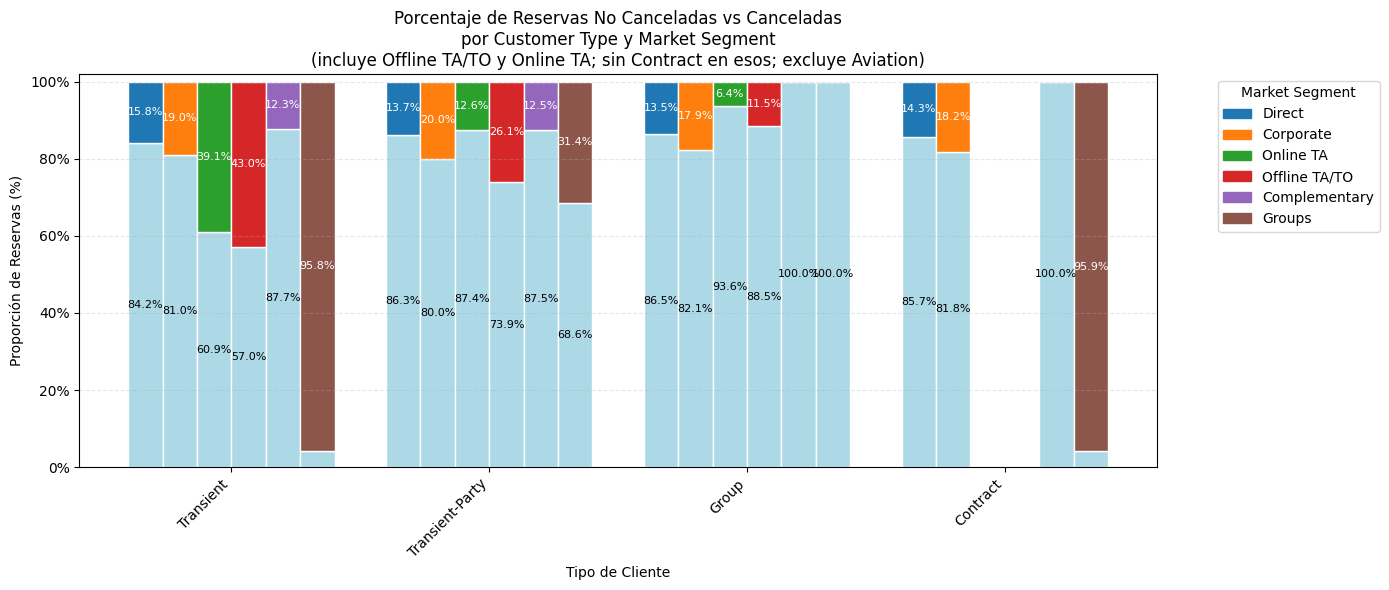

In [108]:
# Filtrar:
#    - Excluir Aviation por completo
#    - Incluir Offline TA/TO y Online TA
#    - Pero para esos dos segmentos, excluir las reservas con customer_type "Contract"
df_f = df[df['market_segment'] != 'Aviation'].copy()
mask_exclude_contract = (
    df_f['market_segment'].isin(['Offline TA/TO', 'Online TA']) &
    (df_f['customer_type'] == 'Contract')
)
df_f = df_f[~mask_exclude_contract]

# 3. Agrupar para contar canceladas y no canceladas
grp = (
    df_f
      .groupby(['customer_type','market_segment','is_canceled'], observed=False)
      .size()
      .unstack(fill_value=0)
      .rename(columns={0:'not_canceled', 1:'canceled'})
)

# 4. Calcular proporciones
grp['total'] = grp['not_canceled'] + grp['canceled']
grp['p_not'] = grp['not_canceled'] / grp['total']
grp['p_yes'] = grp['canceled']     / grp['total']
grp = grp.reset_index()

# 5. Listas ordenadas de categorías
customer_types  = df_f['customer_type'].drop_duplicates().tolist()
market_segments = df_f['market_segment'].drop_duplicates().tolist()
n_ct = len(customer_types)
n_ms = len(market_segments)

# 6. Posiciones y ancho
x = np.arange(n_ct)
total_width = 0.8
w_ms = total_width / n_ms

# 7. Definir colores para cada market_segment
palette = plt.get_cmap('tab10')
colors = {ms: palette(i) for i, ms in enumerate(market_segments)}

fig, ax = plt.subplots(figsize=(14,6))

# 8. Dibujar barras apiladas
for j, ms in enumerate(market_segments):
    offset = (j - (n_ms-1)/2) * w_ms
    xpos = x + offset

    p_not = []
    p_yes = []
    for ct in customer_types:
        row = grp[(grp['customer_type']==ct) & (grp['market_segment']==ms)]
        if not row.empty:
            p_not.append(row['p_not'].iloc[0])
            p_yes.append(row['p_yes'].iloc[0])
        else:
            p_not.append(0)
            p_yes.append(0)

    ax.bar(xpos, p_not, w_ms, color='lightblue', edgecolor='white')
    ax.bar(xpos, p_yes, w_ms, bottom=p_not, color=colors[ms], edgecolor='white')

    # Etiquetas de porcentaje si >5%
    for i in range(n_ct):
        if p_not[i] > 0.05:
            ax.text(xpos[i], p_not[i]/2,
                    f"{p_not[i]*100:.1f}%", ha='center', va='center', fontsize=8)
        if p_yes[i] > 0.05:
            ax.text(xpos[i], p_not[i] + p_yes[i]/2,
                    f"{p_yes[i]*100:.1f}%", ha='center', va='center', fontsize=8, color='white')

# 9. Configuración final
ax.set_xticks(x)
ax.set_xticklabels(customer_types, rotation=45, ha='right')
ax.set_xlabel('Tipo de Cliente')
ax.set_ylabel('Proporción de Reservas (%)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0,1.02)
ax.set_title(
    'Porcentaje de Reservas No Canceladas vs Canceladas\n'
    'por Customer Type y Market Segment\n'
    '(incluye Offline TA/TO y Online TA; sin Contract en esos; excluye Aviation)'
)

# Leyenda de market segments
handles = [plt.matplotlib.patches.Patch(color=colors[ms], label=ms) 
           for ms in market_segments]
ax.legend(handles=handles, title='Market Segment', bbox_to_anchor=(1.05,1), loc='upper left')

ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#################################################################################################################################

# 1. Filtrar como especificaste
df_f = df[df['market_segment'] != 'Aviation'].copy()
mask_exclude_contract = (
    df_f['market_segment'].isin(['Offline TA/TO', 'Online TA']) &
    (df_f['customer_type'] == 'Contract')
)
df_f = df_f[~mask_exclude_contract]

# 2. Agrupamiento y proporciones
grp = (
    df_f
    .groupby(['customer_type', 'market_segment', 'is_canceled'], observed=False)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'not_canceled', 1: 'canceled'})
    .reset_index()
)
grp['total'] = grp['not_canceled'] + grp['canceled']
grp['p_not'] = grp['not_canceled'] / grp['total']
grp['p_yes'] = grp['canceled'] / grp['total']

# 3. Ejes
customer_types = sorted(df_f['customer_type'].unique())
market_segments = sorted(df_f['market_segment'].unique())
n_ct = len(customer_types)
n_ms = len(market_segments)

x_base = np.arange(n_ct)
total_width = 0.8
w_ms = total_width / n_ms

# 4. Colores
import matplotlib.pyplot as plt
palette = plt.get_cmap('tab10')
colors = {ms: f'rgba{tuple(int(c*255) for c in palette(i)[:3]) + (1,)}' for i, ms in enumerate(market_segments)}

# 5. Crear figura
fig = go.Figure()

for j, ms in enumerate(market_segments):
    offset = (j - (n_ms - 1) / 2) * w_ms
    xpos = x_base + offset

    p_not, p_yes = [], []
    for ct in customer_types:
        row = grp[(grp['customer_type'] == ct) & (grp['market_segment'] == ms)]
        if not row.empty:
            p_not.append(row['p_not'].iloc[0])
            p_yes.append(row['p_yes'].iloc[0])
        else:
            p_not.append(0)
            p_yes.append(0)

    # Barr

In [74]:
# df['arrival_date'] = pd.to_datetime(df.get('arrival_date', df.columns[0]), errors='coerce')

# # 2. Limpiar datos según tu lógica
# df = df[~df['market_segment'].isin(['Aviation'])]
# mask = df['market_segment'].isin(['Offline TA/TO', 'Online TA']) & (df['customer_type'] == 'Contract')
# df = df[~mask]

# # 3. Definir tramos de lead_time
# bins = [0, 7, 14, 30, 60, 180, 365, float('inf')]
# labels = ['0-7', '8-14', '15-30', '31-60', '61-180', '181-365', '>365']
# df['lead_time_bin'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=True)

# # 4. Agrupar y calcular proporciones
# grp = (
#     df
#     .groupby(['lead_time_bin', 'customer_type', 'market_segment', 'is_canceled'], observed=False)
#     .size()
#     .unstack(fill_value=0)
#     .rename(columns={0: 'not_canceled', 1: 'canceled'})
#     .reset_index()
# )

# grp['total'] = grp['not_canceled'] + grp['canceled']
# grp['cancel_pct'] = grp['canceled'] / grp['total']

# # 5. Obtener combinaciones únicas
# customer_types = sorted(df['customer_type'].unique())
# market_segments = sorted(df['market_segment'].unique())

# # 6. Graficar por combinación
# for ct in customer_types:
#     for ms in market_segments:
#         subgrp = grp[(grp['customer_type'] == ct) & (grp['market_segment'] == ms)]
#         if not subgrp.empty:
#             fig = px.bar(
#                 subgrp,
#                 x='lead_time_bin',
#                 y='cancel_pct',
#                 text=subgrp['cancel_pct'].apply(lambda x: f"{x:.0%}"),
#                 labels={'cancel_pct': 'Porcentaje Canceladas', 'lead_time_bin': 'Lead Time'},
#                 title=f"{ct} - {ms}",
#                 hover_data={'canceled': True, 'total': True},
#                 category_orders={"lead_time_bin": labels}
#             )
#             fig.update_traces(textposition='outside', marker_color='crimson')
#             fig.update_yaxes(tickformat='.0%', range=[0, 1])
#             fig.update_layout(height=400, margin=dict(t=60, b=40))
#             fig.show()

In [76]:
# df['arrival_date'] = pd.to_datetime(df.get('arrival_date', df.columns[0]), errors='coerce')

# # 2. Limpiar datos según tu lógica
# df = df[~df['market_segment'].isin(['Aviation'])]
# mask = df['market_segment'].isin(['Offline TA/TO', 'Online TA']) & (df['customer_type'] == 'Contract')
# df = df[~mask]

# # 3. Definir tramos de lead_time
# bins = [0, 7, 14, 30, 60, 180, 365, float('inf')]
# labels = ['0-7', '8-14', '15-30', '31-60', '61-180', '181-365', '>365']
# df['lead_time_bin'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=True)

# # 4. Agrupar y calcular proporciones
# grp = (
#     df
#     .groupby(['lead_time_bin', 'customer_type', 'market_segment', 'is_canceled'], observed=False)
#     .size()
#     .unstack(fill_value=0)
#     .rename(columns={0: 'not_canceled', 1: 'canceled'})
#     .reset_index()
# )

# grp['total'] = grp['not_canceled'] + grp['canceled']
# grp['cancel_pct'] = grp['canceled'] / grp['total']

# # 5. Obtener combinaciones únicas
# customer_types = sorted(df['customer_type'].unique())
# market_segments = sorted(df['market_segment'].unique())

# # 6. Graficar por combinación
# for ct in customer_types:
#     for ms in market_segments:
#         subgrp = grp[(grp['customer_type'] == ct) & (grp['market_segment'] == ms)]
#         if not subgrp.empty:
#             fig = px.bar(
#                 subgrp,
#                 x='lead_time_bin',
#                 y='cancel_pct',
#                 text=subgrp['cancel_pct'].apply(lambda x: f"{x:.0%}"),
#                 labels={'cancel_pct': 'Porcentaje Canceladas', 'lead_time_bin': 'Lead Time'},
#                 title=f"{ct} - {ms}",
#                 hover_data={'canceled': True, 'total': True},
#                 category_orders={"lead_time_bin": labels}
#             )
#             fig.update_traces(textposition='outside', marker_color='crimson')
#             fig.update_yaxes(tickformat='.0%', range=[0, 1])
#             fig.update_layout(height=400, margin=dict(t=60, b=40))
#             fig.show()
